In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import matplotlib.patches as patches

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from torchvision import transforms
DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = 'images'
DIR_TEST = f'{DIR_INPUT}/test'

In [31]:
train_df = pd.read_csv('images_boxes.csv')
train_df

,image_id,worm_type,min_X,min_Y,max_X,max_Y
0,id_8ada71185e18dc8838b4925b.jpg,1,2377.970000,156.770000,2478.890000,297.860000
1,id_8ada71185e18dc8838b4925b.jpg,1,715.390000,1221.460000,939.820000,1319.680000
2,id_8ada71185e18dc8838b4925b.jpg,2,1129.730000,1558.060000,1559.700000,1966.300000
3,id_bc86d3cfd0c0463fa5cae33e.jpg,2,1743.676282,1537.210067,2090.216400,1799.814857
4,id_bc86d3cfd0c0463fa5cae33e.jpg,2,2162.137567,1676.304250,2342.256859,1952.269926
...,...,...,...,...,...,...
136970,id_23617d0cdd8f04091b50106d.jpg,1,2177.440000,1777.340000,2221.630000,1835.630000
136971,id_23617d0cdd8f04091b50106d.jpg,1,2376.280000,1610.920000,2471.710000,1685.660000
136972,id_23617d0cdd8f04091b50106d.jpg,1,1732.730000,2174.090000,1819.700000,2248.830000
136973,id_23617d0cdd8f04091b50106d.jpg,1,1940.040000,2445.330000,2003.500000,2477.770000


In [32]:
import imagesize

def get_weight(x):
    width, height = imagesize.get("images/"+x)
    return width

train_df['weight']=train_df['image_id'].apply(get_weight)
def get_height(x):
    width, height = imagesize.get("images/"+x)
    return height
train_df['height']=train_df['image_id'].apply(get_height)

train_df['min_X_res']=(train_df['min_X']/train_df['weight'])*240
train_df['min_Y_res']=(train_df['min_Y']/train_df['height'])*240
train_df['max_X_res']=(train_df['max_X']/train_df['weight'])*240
train_df['max_Y_res']=(train_df['max_Y']/train_df['height'])*240

In [33]:
train_df.to_csv('box_resized.csv',index=False)

In [20]:
from PIL import Image
imgs = [image for image in train_df['image_id']] 
for x in imgs:
    image = Image.open('images/'+x)
    new_image = image.resize((240, 240))
    new_image.save('images_resized/'+x)

tensor([ 68.4693, 132.0480,  96.2453, 144.6480])
tensor([ 76.5333, 100.6880,  90.6453, 119.7840])
tensor([51.3707, 78.8480, 68.3200, 94.9200])


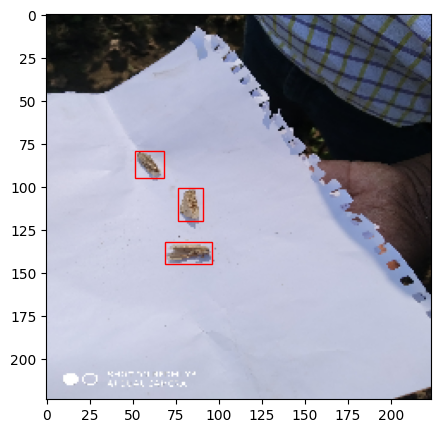

In [8]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        print(box)
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target,_ = BollwormDataset(files_dir,224,224)[798]
plot_img_bbox(img, target)